# Modified CNN Training for Animal Image Dataset

This notebook uses the CNN model from `92_21_.ipynb` to train on the animal images dataset.

In [1]:
# Install the torchinfo package for showing the network architecture information
!pip install torchinfo -qqq

In [2]:
# Import the necessary libraries
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim, no_grad
from torch.utils.data import Dataset, DataLoader
import torch.optim.lr_scheduler as lr_scheduler
from torchinfo import summary

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import pickle
import sys
import time
import os
from PIL import Image

In [3]:
# To configure the usage of a GPU (cuda) or MPS (Apple) if either of them is available
has_mps = torch.backends.mps.is_built()
device = "cuda" if torch.cuda.is_available() else "mps" if has_mps else "cpu"
print(f"Python version: {sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Set seed for reproducibility
seed = 4016
torch.manual_seed(seed)


Python version: 3.11.9
PyTorch version: 2.4.1+cu118
Device: cuda


In [4]:
class PetDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.class_to_idx = {cls: idx for idx, cls in enumerate(sorted(set(labels)))}
        self.idx_to_class = {idx: cls for cls, idx in self.class_to_idx.items()}
        self.numeric_labels = [self.class_to_idx[label] for label in labels]
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.numeric_labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [ ]:

# Define transformations and load data
def load_pet_data(dataset_path, train_split=0.8, batch_size=128):
    # Define transformations
    train_transform = transforms.Compose([
        transforms.Resize((64, 64)),  # Changed to 64x64
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),  
        transforms.RandomRotation(15),
        transforms.RandomCrop(64, padding=6),  # Adjusted padding for 64x64
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
    ])

    test_transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    # Initialize lists for image paths and labels
    image_paths = []
    labels = []

    # Collect all image paths and labels
    for label in os.listdir(dataset_path):
        label_path = os.path.join(dataset_path, label)
        if os.path.isdir(label_path):
            for image_name in os.listdir(label_path):
                image_path = os.path.join(label_path, image_name)
                image_paths.append(image_path)
                labels.append(label)

    # Split data into train and test sets
    indices = np.random.permutation(len(image_paths))
    split_idx = int(len(indices) * train_split)
    train_indices = indices[:split_idx]
    test_indices = indices[split_idx:]

    # Create train and test datasets
    train_dataset = PetDataset(
        [image_paths[i] for i in train_indices],
        [labels[i] for i in train_indices],
        transform=train_transform
    )

    test_dataset = PetDataset(
        [image_paths[i] for i in test_indices],
        [labels[i] for i in test_indices],
        transform=test_transform
    )

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0
    )

    classes = sorted(set(labels))
    return train_loader, test_loader, train_dataset, test_dataset, classes

# Load the data
dataset_path = './Choose pet datset for kaggle/'  # Update with your path
train_loader, test_loader, train_dataset, test_dataset, classes = load_pet_data(dataset_path)

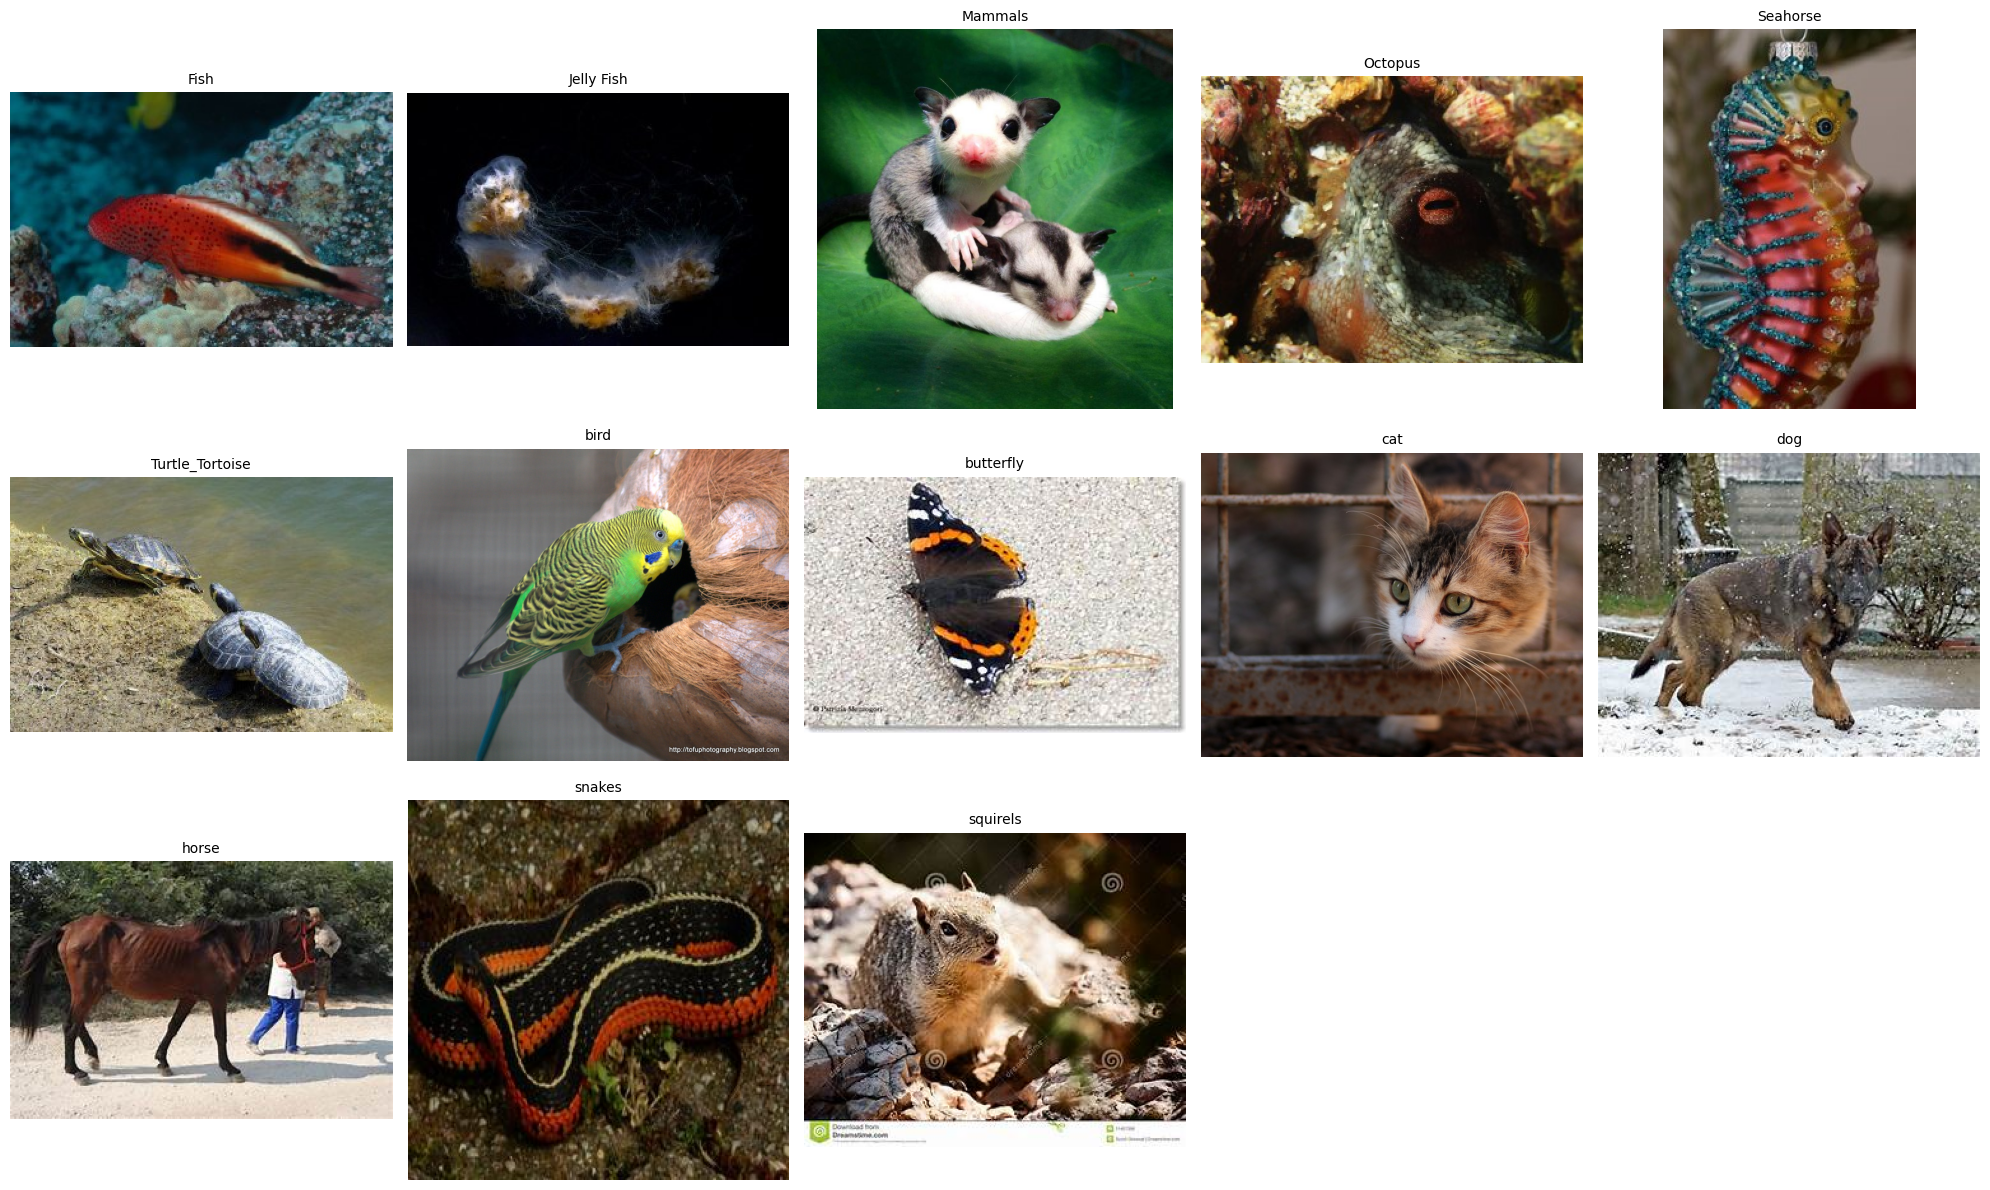

In [6]:
import matplotlib.pyplot as plt
import random
from PIL import Image
import os

# Function to get one sample image per class from your dataset structure
def visualize_sample_per_class(dataset_path):
    # Get all class names (subdirectories)
    classes = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])
    
    # Dictionary to store one sample image path for each class
    samples_per_class = {}
    
    # Get one random image from each class
    for cls in classes:
        class_path = os.path.join(dataset_path, cls)
        # Get all images in the class directory
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if images:  # If there are images in this class
            # Select a random image
            sample_image = random.choice(images)
            samples_per_class[cls] = os.path.join(class_path, sample_image)
    
    # Calculate grid dimensions
    n_classes = len(classes)
    n_cols = 5  # You can adjust this
    n_rows = (n_classes + n_cols - 1) // n_cols  # Ceiling division
    
    # Create the plot
    plt.figure(figsize=(20, 4 * n_rows))  # Adjust figure size based on number of rows
    
    for i, (label, img_path) in enumerate(samples_per_class.items()):
        plt.subplot(n_rows, n_cols, i + 1)
        image = Image.open(img_path).convert("RGB")
        plt.imshow(image)
        plt.title(label, fontsize=10)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_sample_per_class(dataset_path)

In [ ]:
# Modified CNN architecture for 64x64 inputs
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        # First block
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.3)
        
        # Add self-attention after first block
        self.attention1 = SelfAttention(64)
        
        # Second block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.dropout2 = nn.Dropout(0.3)
        
        # Add self-attention after second block
        self.attention2 = SelfAttention(128)
        
        # Third block
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.dropout3 = nn.Dropout(0.2)
        
        # Add self-attention after third block
        self.attention3 = SelfAttention(256)
        
        # Fully connected layers
        # After 3 max pooling layers: 64 -> 32 -> 16 -> 8
        self.fc1 = nn.Linear(256 * 8 * 8, 1024)
        self.bn7 = nn.BatchNorm1d(1024)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        # First block
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout1(x)
        x = self.attention1(x)
        
        # Second block
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = self.dropout2(x)
        x = self.attention2(x)
        
        # Third block
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool(x)
        x = self.dropout3(x)
        x = self.attention3(x)
        
        # Flatten and fully connected layers
        x = x.view(-1, 256 * 8 * 8)
        x = F.relu(self.bn7(self.fc1(x)))
        x = self.dropout4(x)
        x = self.fc2(x)
        
        return x
    
# Self-attention module
class SelfAttention(nn.Module):
  def __init__(self, in_channels):
      super().__init__()
      # Reduce channel dimensions for efficiency
      self.query = nn.Conv2d(in_channels, in_channels//8, 1)
      self.key = nn.Conv2d(in_channels, in_channels//8, 1)
      self.value = nn.Conv2d(in_channels, in_channels, 1)
      self.gamma = nn.Parameter(torch.zeros(1))  # Learnable scaling parameter

  def forward(self, x):
      batch_size, channels, height, width = x.size()
      
      # Create query, key, value
      query = self.query(x).view(batch_size, -1, height*width)
      key = self.key(x).view(batch_size, -1, height*width)
      value = self.value(x).view(batch_size, -1, height*width)
      
      # Calculate attention scores
      attention = torch.bmm(query.transpose(1,2), key)
      attention = F.softmax(attention, dim=2)
      
      # Apply attention to values
      out = torch.bmm(value, attention.transpose(1,2))
      out = out.view(batch_size, channels, height, width)
      
      # Apply learned scaling
      out = self.gamma * out + x
      
      return out


# Initialize model
model = CNN(num_classes=len(classes))

In [8]:
#summary(model=model, input_size=(1, 3, 32, 32), col_width=15,
#        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
#        row_settings=['var_names'], verbose=0)

In [ ]:
# Create a Models folder to store the checkpoints
!mkdir Models

# Training parameters
EPOCHS = 150
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.05)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.01,
    steps_per_epoch=len(train_loader),
    epochs=EPOCHS,
    pct_start=0.3
)

#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True, min_lr=0)

�l�ؿ����ɮ� Models �w�g�s�b�C
g:\python\ee4016 ai\venv\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [10]:
loss_hist, acc_hist = [], []  # Lists to store training loss and accuracy
loss_hist_test, acc_hist_test = [], []  # Lists to store validation loss and accuracy

model.to(device)  # Move the model to the specified device
print("Training started.\n")

for epoch in range(1, EPOCHS + 1):
    time_ckpt = time.time()
    print(f"EPOCH: {epoch}", end=" ")
    
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch, labels in train_loader:
        batch, labels = batch.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    avg_acc = correct / total
    loss_hist.append(avg_loss)
    acc_hist.append(avg_acc)

    # Validation phase
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for batch, labels in test_loader:
            batch, labels = batch.to(device), labels.to(device)
            outputs = model(batch)
            loss = criterion(outputs, labels)
            
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            test_loss += loss.item()
    
    avg_loss_test = test_loss / len(test_loader)
    avg_acc_test = correct_test / total_test
    loss_hist_test.append(avg_loss_test)
    acc_hist_test.append(avg_acc_test)
    scheduler.step(avg_loss_test)
    # Save model checkpoint
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': avg_loss,
        'test_loss': avg_loss_test,
    }, f"Models/pet_model_{epoch}.pth")

    print(f"Train Loss: {avg_loss:.3f}", end=" ")
    print(f"Test Loss: {avg_loss_test:.3f}", end=" ")
    print(f"Train Accuracy: {avg_acc*100:.2f}%", end=" ")
    print(f"Test Accuracy: {avg_acc_test*100:.2f}%", end=" ")
    print(f"Time: {time.time() - time_ckpt:.2f}s")

Training started.

EPOCH: 1 Train Loss: 1.948 Test Loss: 1.782 Train Accuracy: 38.21% Test Accuracy: 45.63% Time: 44.38s
EPOCH: 2 Train Loss: 1.742 Test Loss: 1.689 Train Accuracy: 45.37% Test Accuracy: 48.85% Time: 43.11s
EPOCH: 3 Train Loss: 1.632 Test Loss: 1.540 Train Accuracy: 49.12% Test Accuracy: 52.68% Time: 43.12s
EPOCH: 4 Train Loss: 1.537 Test Loss: 1.660 Train Accuracy: 53.11% Test Accuracy: 51.08% Time: 43.02s
EPOCH: 5 Train Loss: 1.469 Test Loss: 1.448 Train Accuracy: 55.47% Test Accuracy: 56.15% Time: 43.19s
EPOCH: 6 Train Loss: 1.423 Test Loss: 1.351 Train Accuracy: 57.19% Test Accuracy: 61.42% Time: 43.68s
EPOCH: 7 Train Loss: 1.341 Test Loss: 1.368 Train Accuracy: 60.62% Test Accuracy: 61.19% Time: 43.50s
EPOCH: 8 Train Loss: 1.302 Test Loss: 1.256 Train Accuracy: 62.19% Test Accuracy: 64.48% Time: 43.70s
EPOCH: 9 Train Loss: 1.248 Test Loss: 1.280 Train Accuracy: 64.42% Test Accuracy: 63.55% Time: 44.71s
EPOCH: 10 Train Loss: 1.206 Test Loss: 1.188 Train Accuracy: 66

KeyboardInterrupt: 

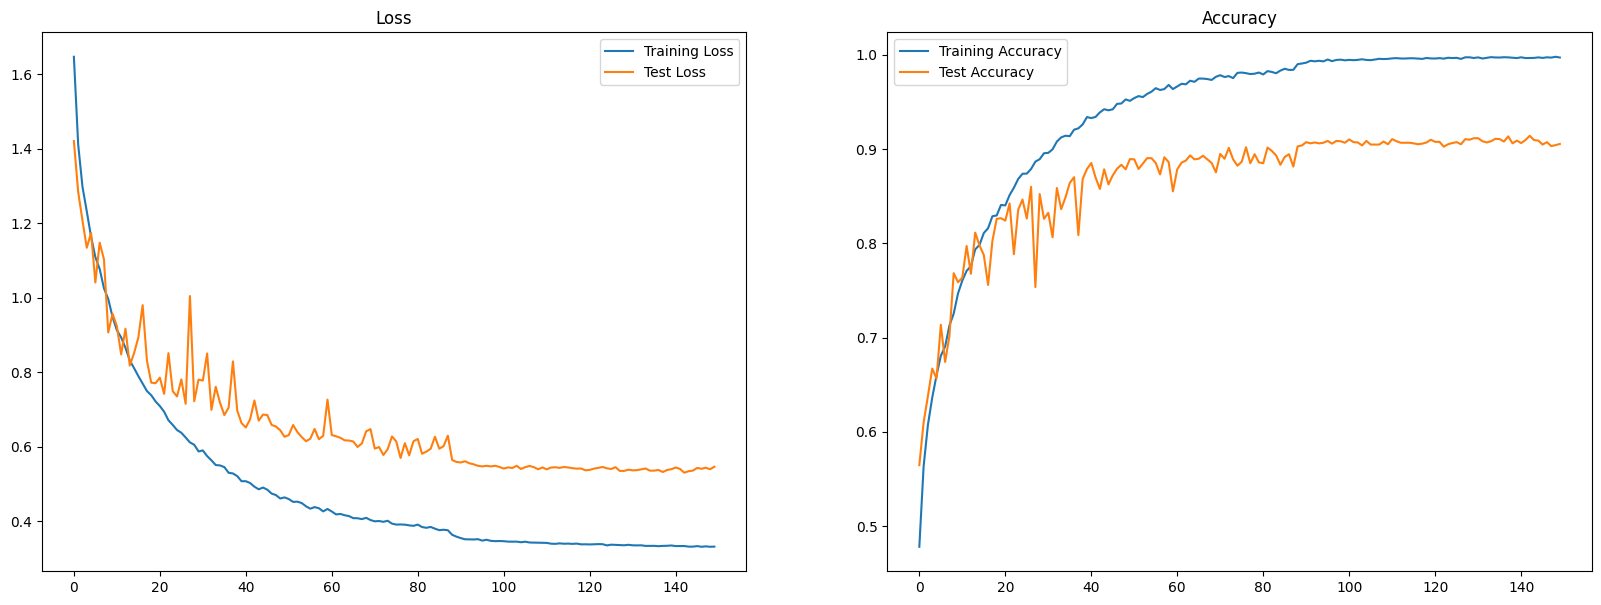

In [ ]:
plots = [(loss_hist, loss_hist_test), (acc_hist, acc_hist_test)]
plt_labels = [("Training Loss", "Test Loss"), ("Training Accuracy", "Test Accuracy")]
plt_titles = ["Loss", "Accuracy"]

plt.figure(figsize=(20, 7))
for i in range(2):
    ax = plt.subplot(1, 2, i+1)
    ax.plot(plots[i][0], label=plt_labels[i][0])
    ax.plot(plots[i][1], label=plt_labels[i][1])
    ax.set_title(plt_titles[i])
    ax.legend()
plt.show()

In [ ]:
torch.save(model.state_dict(), 'pet_classification_model.pth')

In [ ]:
# Get predictions
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Create confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
conf_df = pd.DataFrame(conf_matrix, index=classes, columns=classes)
print("\nConfusion Matrix:")
print(conf_df)

# Create classification report
report = classification_report(all_labels, all_preds, target_names=classes, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print("\nClassification Report:")
print(report_df)


Confusion Matrix:
            Amphibians  Mammals  Reptiles  bird  butterfly  cat  dog  horse  \
Amphibians          39        1         2     1          2    1    4      0   
Mammals              0       41         0     2          0    3   15      0   
Reptiles             7        0        13     0          1    1    1      0   
bird                 0        1         0    47          0    2    5      1   
butterfly            0        0         0     0         53    2    4      0   
cat                  0        2         0     1          0  314   37      0   
dog                  1        1         0     0          4    5  960      1   
horse                0        0         0     0          0    0   32     66   
spider               1        0         0     1          1    2   12      2   
squirels             0        0         0     0          1    7   35      0   

            spider  squirels  
Amphibians       5         0  
Mammals          4         4  
Reptiles         3

In [ ]:
# Select best model
best_acc = max(acc_hist_test)
best_epoch = acc_hist_test.index(best_acc) + 1

print(f"Best accuracy on test set: {best_acc*100:.2f}%")
print(f"Best epoch: {best_epoch}")

# Load best model
checkpoint = torch.load(f"Models/pet_model_{best_epoch}.pth")
model.load_state_dict(checkpoint['model_state_dict'])

Best accuracy on test set: 91.41%
Best epoch: 143


C:\Users\taole\AppData\Local\Temp\ipykernel_22868\282154938.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f"Models/pet_model_{best_epoch}.pth")

<All keys matched successfully>

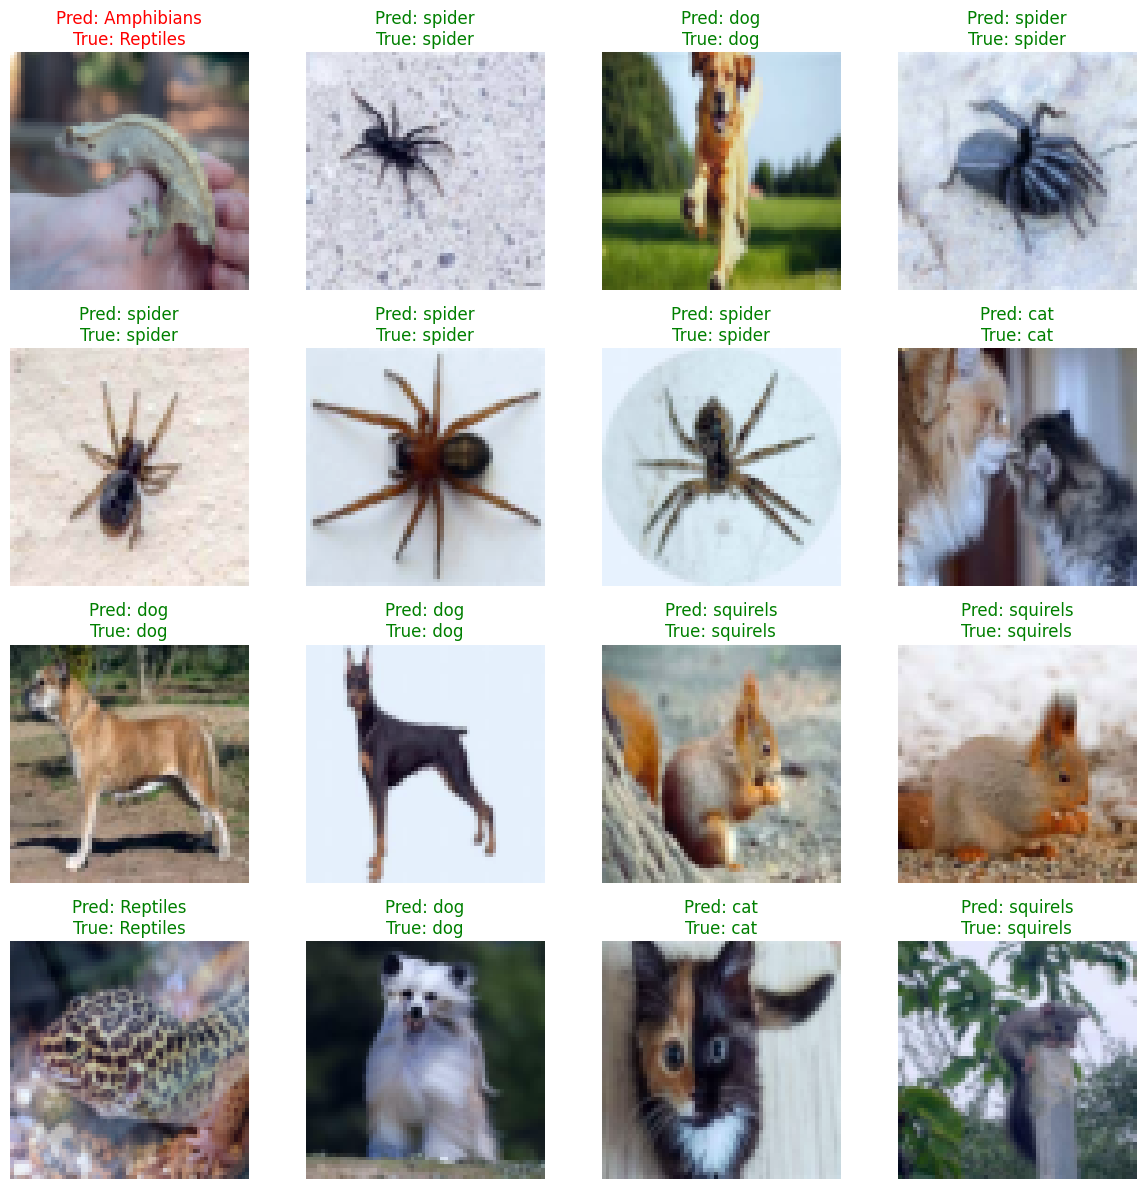

In [ ]:
def visualize_predictions(num_images=16):
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    for idx, ax in enumerate(axes.flat):
        if idx < num_images:
            image = images[idx].cpu().permute(1, 2, 0)
            image = (image - image.min()) / (image.max() - image.min())
            ax.imshow(image)
            ax.axis('off')
            color = 'green' if preds[idx] == labels[idx] else 'red'
            ax.set_title(f'Pred: {classes[preds[idx]]}\nTrue: {classes[labels[idx]]}', color=color)
    plt.tight_layout()
    plt.show()

visualize_predictions()